In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone --branch baseline_boosting https://{token}@github.com/FrancescoZanella/RecSysChallenge2024.git
! git clone https://github.com/ebanalyse/ebnerd-benchmark.git

fatal: destination path 'RecSysChallenge2024' already exists and is not an empty directory.
fatal: destination path 'ebnerd-benchmark' already exists and is not an empty directory.


In [2]:
%cd /kaggle/working/RecSysChallenge2024/src

/kaggle/working/RecSysChallenge2024/src


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import polars as pl
import scipy.stats as stats
import gc

from ebrec.utils._descriptive_analysis import (
    min_max_impression_time_behaviors, 
    min_max_impression_time_history
)
from ebrec.utils._polars import slice_join_dataframes
from ebrec.utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    truncate_history,
)
from ebrec.utils._constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_USER_COL
)
from ebrec.evaluation.metrics_protocols import *

from catboost import CatBoostClassifier

In [29]:
articles = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/articles.parquet')

behaviors_train = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/train/behaviors.parquet')
history_train = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/train/history.parquet')

behaviors_val = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/validation/behaviors.parquet')
history_val = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/validation/history.parquet')

In [5]:
unique_entities = articles.select('entity_groups').explode('entity_groups')['entity_groups'].unique().to_list()
unique_entities = [e for e in unique_entities if e is not None]
unique_entities

['MISC', 'PER', 'LOC', 'PROD', 'ORG', 'EVENT']

In [6]:
NPRATIO = 2
train_ds = behaviors_train.pipe(
    sampling_strategy_wu2019, npratio=NPRATIO, shuffle=False, with_replacement=True, seed=123
).pipe(create_binary_labels_column, shuffle=True, seed=123)

In [7]:
# dropping duplicates that can occur because of sampling strategy
train_ds = train_ds.select(['impression_id', 'article_ids_inview', 'article_id', 'impression_time', 'labels', 
                            'device_type', 'read_time', 'scroll_percentage', 'user_id', 'is_sso_user', 'gender',
                            'age', 'is_subscriber']) \
    .explode(['article_ids_inview', 'labels']) \
    .rename({'article_ids_inview': 'article', 'labels': 'target'}) \
    .unique(['impression_id', 'article']) \
    .with_columns(
        pl.col('impression_time').dt.weekday().alias('weekday'),
        pl.col('impression_time').dt.hour().alias('hour'),
        pl.col('article').cast(pl.Int32),
    ).join(articles.select(['article_id', 'premium', 'published_time', 'category', 
                            'sentiment_score', 'sentiment_label', 'entity_groups']),
           left_on='article', right_on='article_id', how='left') \
    .with_columns(
        (pl.col('impression_time') - pl.col('published_time')).dt.total_days().alias('article_delay_days'),
        (pl.col('impression_time') - pl.col('published_time')).dt.total_hours().alias('article_delay_hours')
    ).drop(['impression_time', 'published_time', 'article_id']) \
    .with_columns(
        pl.col('entity_groups').list.contains(entity).alias(f'Entity_{entity}_Present')
        for entity in unique_entities
    )

train_ds.head()

impression_id,article,target,device_type,read_time,scroll_percentage,user_id,is_sso_user,gender,age,is_subscriber,weekday,hour,premium,category,sentiment_score,sentiment_label,entity_groups,article_delay_days,article_delay_hours,Entity_MISC_Present,Entity_PER_Present,Entity_LOC_Present,Entity_PROD_Present,Entity_ORG_Present,Entity_EVENT_Present
u32,i32,i8,i8,f32,f32,u32,bool,i8,i8,bool,i8,i8,bool,i16,f32,str,list[str],i64,i64,bool,bool,bool,bool,bool,bool
149474,9778669,0,2,13.0,null,139836,false,null,null,false,3,7,false,118,0.9481,"""Negative""","[""ORG"", ""ORG"", … ""PROD""]",0,1,false,true,false,true,true,false
149474,9778657,1,2,13.0,null,139836,false,null,null,false,3,7,false,118,0.8347,"""Neutral""","[""MISC"", ""LOC"", … ""LOC""]",0,1,true,true,true,false,true,false
150528,9778682,0,2,25.0,null,143471,false,null,null,false,3,7,false,498,0.9546,"""Negative""","[""PROD"", ""PROD"", … ""PER""]",0,1,false,true,false,true,true,true
153070,7213923,0,1,26.0,100.0,151570,false,null,null,false,3,7,true,565,0.8109,"""Neutral""",[],1761,42266,false,false,false,false,false,false
153071,9775990,0,1,125.0,100.0,151570,false,null,null,false,3,7,false,142,0.5539,"""Neutral""","[""PER"", ""MISC"", … ""EVENT""]",1,43,true,true,true,false,true,true


In [8]:
train_ds.shape

(699537, 26)

# Adding history

## Retrieving Article Features

In [9]:
%%time

from rich.progress import Progress


def get_single_feature_function(f_name, progress_task):
    def get_feature(article_ids):
        progress.update(progress_task, advance=1)
        feature_values = articles.filter(pl.col('article_id').is_in(article_ids)) \
            .select(pl.col(f_name))[f_name].to_list()
        return feature_values
    return get_feature


def get_unique_list_feature_function(f_name, progress_task):
    def get_feature(article_ids):
        progress.update(progress_task, advance=1)
        feature_values = articles.filter(pl.col('article_id').is_in(article_ids)) \
            .select(pl.col(f_name).list.unique())[f_name].to_list()
        return feature_values
    return get_feature


def get_unique_list_exploded_feature_function(f_name, progress_task):
    def get_feature(article_ids):
        progress.update(progress_task, advance=1)
        feature_values = articles.filter(pl.col('article_id').is_in(article_ids)) \
            .select(pl.col(f_name).list.unique()).explode(f_name)[f_name].to_list()
        return feature_values
    return get_feature


# ner_clusters for the moment is not used since there are too much unique values (more than 44k)
columns = ['category', 'article_type', 'sentiment_label', 'sentiment_score']
return_dtypes = [pl.Int64, pl.String, pl.String, pl.Float64]
with Progress() as progress: 
    
    tasks = {}
    for col in columns:
        tasks[col] = progress.add_task(f"Getting {col}", total=history_train.shape[0])
    tasks['entity_groups'] = progress.add_task("Getting entity_groups", total=history_train.shape[0])
    tasks['entity_groups_detailed'] = progress.add_task("Getting detailed entity_groups", total=history_train.shape[0])
    tasks['topics'] = progress.add_task("Getting topics", total=history_train.shape[0])

    history_train = history_train.with_columns(
        [pl.col('article_id_fixed').map_elements(get_single_feature_function(col, tasks[col]), 
                                                 return_dtype=pl.List(dtype)).alias(col)
         for col, dtype in zip(columns, return_dtypes)] + \
        [pl.col('article_id_fixed').map_elements(get_unique_list_exploded_feature_function('entity_groups', tasks['entity_groups']), 
                                                 return_dtype=pl.List(pl.String)).alias('entity_groups'),
         pl.col('article_id_fixed').map_elements(get_unique_list_exploded_feature_function('topics', tasks['topics']), 
                                                 return_dtype=pl.List(pl.String)).alias('topics_flatten'),
         pl.col('article_id_fixed').map_elements(get_unique_list_feature_function('entity_groups', tasks['entity_groups_detailed']), 
                                                 return_dtype=pl.List(pl.List(pl.String))).alias('entity_groups_detailed')]
    )
    
history_train.head(2)

Output()

CPU times: user 3min 37s, sys: 22.1 s, total: 3min 59s
Wall time: 2min 24s


user_id,impression_time_fixed,scroll_percentage_fixed,article_id_fixed,read_time_fixed,category,article_type,sentiment_label,sentiment_score,entity_groups,topics_flatten,entity_groups_detailed
u32,list[datetime[μs]],list[f32],list[i32],list[f32],list[i64],list[str],list[str],list[f64],list[str],list[str],list[list[str]]
13538,"[2023-04-27 10:17:43, 2023-04-27 10:18:01, … 2023-05-17 20:36:34]","[100.0, 35.0, … 100.0]","[9738663, 9738569, … 9769366]","[17.0, 12.0, … 16.0]","[565, 572, … 140]","[""article_default"", ""article_fullscreen_gallery"", … ""article_default""]","[""Neutral"", ""Neutral"", … ""Negative""]","[0.8108, 0.7985, … 0.9959]","[null, null, … ""LOC""]","[""Erotik"", ""Livsstil"", … ""Uddannelse""]","[[], [], … [""ORG"", ""PER"", ""LOC""]]"
14241,"[2023-04-27 09:40:18, 2023-04-27 09:40:33, … 2023-05-17 17:08:41]","[100.0, 46.0, … 100.0]","[9738557, 9738528, … 9767852]","[8.0, 9.0, … 12.0]","[457, 457, … 118]","[""article_default"", ""article_default"", … ""article_default""]","[""Negative"", ""Neutral"", … ""Neutral""]","[0.9712, 0.9115, … 0.8372]","[null, ""ORG"", … ""PER""]","[""Privat virksomhed"", ""Erhverv"", … ""Politik""]","[[], [""PER"", ""ORG""], … [""ORG"", ""PER""]]"


## Basic Features

In [10]:
def sentiment_score_strong_pct(labels, scores, label_name, threshold=0.8):
    scores_filter = np.array(labels) == label_name
    label_scores = np.array(scores)[scores_filter]
    return np.sum(label_scores > threshold) / len(labels) if len(label_scores) > 0 else 0

history_train = history_train.with_columns(
    pl.struct(['sentiment_label', 'sentiment_score']).map_elements(
        lambda x: sentiment_score_strong_pct(x['sentiment_label'], x['sentiment_score'], 'Negative')
    ).alias('PctStrongNegative'),
    pl.struct(['sentiment_label', 'sentiment_score']).map_elements(
        lambda x: sentiment_score_strong_pct(x['sentiment_label'], x['sentiment_score'], 'Neutral')
    ).alias('PctStrongNeutral'),
    pl.struct(['sentiment_label', 'sentiment_score']).map_elements(
        lambda x: sentiment_score_strong_pct(x['sentiment_label'], x['sentiment_score'], 'Positive')
    ).alias('PctStrongPositive')
).with_columns(
    pl.col('read_time_fixed').list.len().alias('NumArticlesHistory'),
    pl.col('read_time_fixed').list.median().alias('MedianReadTime'),
    pl.col('read_time_fixed').list.max().alias('MaxReadTime'),
    pl.col('read_time_fixed').list.sum().alias('TotalReadTime'),
    pl.col('scroll_percentage_fixed').list.median().alias('MedianScrollPercentage'),
    pl.col('scroll_percentage_fixed').list.max().alias('MaxScrollPercentage'),
    pl.col('impression_time_fixed').list.eval(pl.element().dt.weekday()).alias('weekdays'),
    pl.col('impression_time_fixed').list.eval(pl.element().dt.hour()).alias('hours'),
).with_columns(
    pl.col('weekdays').map_elements(lambda x: stats.mode(x)[0], return_dtype=pl.Int64).cast(pl.Int8).alias('MostFrequentWeekday'),
    pl.col('hours').map_elements(lambda x: stats.mode(x)[0], return_dtype=pl.Int64).cast(pl.Int8).alias('MostFrequentHour'),
    pl.col('category').map_elements(lambda x: stats.mode(x)[0], return_dtype=pl.Int64).cast(pl.Int16).alias('MostFrequentCategory'),
    (1 - (pl.col('article_type').list.count_matches('article_default') / pl.col('NumArticlesHistory'))).alias('PctNotDefaultArticles'),
    (pl.col('sentiment_label').list.count_matches('Negative') / pl.col('NumArticlesHistory')).alias('NegativePct'),
    (pl.col('sentiment_label').list.count_matches('Positive') / pl.col('NumArticlesHistory')).alias('PositivePct'),
    (pl.col('sentiment_label').list.count_matches('Neutral') / pl.col('NumArticlesHistory')).alias('NeutralPct'),
).drop(
    ['read_time_fixed', 'scroll_percentage_fixed', 'impression_time_fixed', 
     'weekdays', 'hours', 'sentiment_label', 'sentiment_score', 'article_type']
).with_columns(
    (pl.col('entity_groups').list.count_matches(entity) / pl.col('NumArticlesHistory')).alias(f'{entity}Pct')
    for entity in unique_entities
).drop('entity_groups')

history_train.head(2)

user_id,article_id_fixed,category,topics_flatten,entity_groups_detailed,PctStrongNegative,PctStrongNeutral,PctStrongPositive,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,MostFrequentWeekday,MostFrequentHour,MostFrequentCategory,PctNotDefaultArticles,NegativePct,PositivePct,NeutralPct,MISCPct,PERPct,LOCPct,PRODPct,ORGPct,EVENTPct
u32,list[i32],list[i64],list[str],list[list[str]],f64,f64,f64,u32,f32,f32,f32,f32,f32,i8,i8,i16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
13538,"[9738663, 9738569, … 9769366]","[565, 572, … 140]","[""Erotik"", ""Livsstil"", … ""Uddannelse""]","[[], [], … [""ORG"", ""PER"", ""LOC""]]",0.54792,0.115732,0.070524,582,6.0,672.0,7192.0,32.0,100.0,3,3,118,0.073883,0.601375,0.12543,0.223368,0.16323,0.819588,0.719931,0.280069,0.87457,0.159794
14241,"[9738557, 9738528, … 9767852]","[457, 457, … 118]","[""Privat virksomhed"", ""Erhverv"", … ""Politik""]","[[], [""PER"", ""ORG""], … [""ORG"", ""PER""]]",0.541401,0.146497,0.057325,179,19.0,1574.0,7754.0,100.0,100.0,3,13,118,0.139665,0.553073,0.094972,0.22905,0.162011,0.776536,0.681564,0.206704,0.810056,0.106145


In [11]:
history_train.shape

(15143, 27)

## Categories and entities

In [12]:
def list_pct_matches_with_col(a, b) -> pl.Expr:
    '''
    Returns an expression to count the number of matching element in a list with another column.
    The polars function count_matches cannot be used since it wants only a single element, 
    variable element from row to row.
    '''
    return pl.when(pl.col(a).list.len() == 0).then(0.0) \
        .otherwise((pl.col(a).list.len() - (pl.col(a).list.set_difference(pl.col(b))).list.len()) / pl.col(a).list.len())


train_ds = train_ds.join(history_train.drop(['entity_groups_detailed', 'article_id_fixed', 'topics_flatten']), on='user_id', how='left').with_columns(
    (pl.col('category') == pl.col('MostFrequentCategory')).alias('IsFavouriteCategory'),
    pl.col('category_right').list.n_unique().alias('NumberDifferentCategories'),
    list_pct_matches_with_col('category_right', 'category').alias('PctCategoryMatches'),
).drop('category_right')

gc.collect()
    
train_ds.head(2)

impression_id,article,target,device_type,read_time,scroll_percentage,user_id,is_sso_user,gender,age,is_subscriber,weekday,hour,premium,category,sentiment_score,sentiment_label,entity_groups,article_delay_days,article_delay_hours,Entity_MISC_Present,Entity_PER_Present,Entity_LOC_Present,Entity_PROD_Present,Entity_ORG_Present,Entity_EVENT_Present,PctStrongNegative,PctStrongNeutral,PctStrongPositive,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,MostFrequentWeekday,MostFrequentHour,MostFrequentCategory,PctNotDefaultArticles,NegativePct,PositivePct,NeutralPct,MISCPct,PERPct,LOCPct,PRODPct,ORGPct,EVENTPct,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches
u32,i32,i8,i8,f32,f32,u32,bool,i8,i8,bool,i8,i8,bool,i16,f32,str,list[str],i64,i64,bool,bool,bool,bool,bool,bool,f64,f64,f64,u32,f32,f32,f32,f32,f32,i8,i8,i16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,u32,f64
149474,9778669,0,2,13.0,null,139836,false,null,null,false,3,7,false,118,0.9481,"""Negative""","[""ORG"", ""ORG"", … ""PROD""]",0,1,false,true,false,true,true,false,0.631579,0.210526,0.0,19,11.0,88.0,399.0,47.0,100.0,5,19,118,0.052632,0.736842,0.0,0.263158,0.157895,0.894737,0.789474,0.105263,0.894737,0.105263,true,5,0.789474
149474,9778657,1,2,13.0,null,139836,false,null,null,false,3,7,false,118,0.8347,"""Neutral""","[""MISC"", ""LOC"", … ""LOC""]",0,1,true,true,true,false,true,false,0.631579,0.210526,0.0,19,11.0,88.0,399.0,47.0,100.0,5,19,118,0.052632,0.736842,0.0,0.263158,0.157895,0.894737,0.789474,0.105263,0.894737,0.105263,true,5,0.789474


In [13]:
%%time

import tqdm

entities_df = pl.concat(
    (
        rows.select(['impression_id', 'user_id', 'article', 'entity_groups']) \
            .join(history_train.select(['user_id', 'entity_groups_detailed']), on='user_id', how='left') \
            .explode('entity_groups_detailed')
            .with_columns(
                pl.col('entity_groups').list.set_intersection(pl.col('entity_groups_detailed')).list.len().alias('common_entities')
            ).drop(['entity_groups_detailed', 'entity_groups']) \
            .group_by(['impression_id', 'article']).agg(
                pl.col('common_entities').mean().alias('MeanCommonEntities'),
                pl.col('common_entities').max().alias('MaxCommonEntities'),
            )
        for rows in tqdm.tqdm(train_ds.iter_slices(100), total=train_ds.shape[0] // 100)
    )
)
train_ds = train_ds.join(entities_df, on=['impression_id', 'article'], how='left').drop(['entity_groups'])
train_ds.head(2)

6996it [03:29, 33.38it/s]                          


CPU times: user 3min 43s, sys: 20.4 s, total: 4min 3s
Wall time: 3min 29s


impression_id,article,target,device_type,read_time,scroll_percentage,user_id,is_sso_user,gender,age,is_subscriber,weekday,hour,premium,category,sentiment_score,sentiment_label,article_delay_days,article_delay_hours,Entity_MISC_Present,Entity_PER_Present,Entity_LOC_Present,Entity_PROD_Present,Entity_ORG_Present,Entity_EVENT_Present,PctStrongNegative,PctStrongNeutral,PctStrongPositive,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,MostFrequentWeekday,MostFrequentHour,MostFrequentCategory,PctNotDefaultArticles,NegativePct,PositivePct,NeutralPct,MISCPct,PERPct,LOCPct,PRODPct,ORGPct,EVENTPct,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches,MeanCommonEntities,MaxCommonEntities
u32,i32,i8,i8,f32,f32,u32,bool,i8,i8,bool,i8,i8,bool,i16,f32,str,i64,i64,bool,bool,bool,bool,bool,bool,f64,f64,f64,u32,f32,f32,f32,f32,f32,i8,i8,i16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,u32,f64,f64,u32
149474,9778669,0,2,13.0,null,139836,false,null,null,false,3,7,false,118,0.9481,"""Negative""",0,1,false,true,false,true,true,false,0.631579,0.210526,0.0,19,11.0,88.0,399.0,47.0,100.0,5,19,118,0.052632,0.736842,0.0,0.263158,0.157895,0.894737,0.789474,0.105263,0.894737,0.105263,true,5,0.789474,1.894737,3
149474,9778657,1,2,13.0,null,139836,false,null,null,false,3,7,false,118,0.8347,"""Neutral""",0,1,true,true,true,false,true,false,0.631579,0.210526,0.0,19,11.0,88.0,399.0,47.0,100.0,5,19,118,0.052632,0.736842,0.0,0.263158,0.157895,0.894737,0.789474,0.105263,0.894737,0.105263,true,5,0.789474,2.736842,4


## Topics TF-IDF

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
articles = articles.with_columns(
    pl.Series(
        vectorizer.fit_transform(
            articles.with_columns(pl.col('topics').list.join(separator=' '))['topics'].to_list()
        ).toarray()
    ).alias('topics_idf')
)
articles.head(2)

article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,topics_idf
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,list[f64]
3001353,"""Natascha var i…","""Politiet frygt…",2023-06-29 06:20:33,false,"""Sagen om den ø…",2006-08-31 08:06:45,[3150850],"""article_defaul…","""https://ekstra…",[],[],"[""Kriminalitet"", ""Personfarlig kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""","[0.0, 0.0, … 0.0]"
3003065,"""Kun Star Wars …","""Biografgængern…",2023-06-29 06:20:35,false,"""Vatikanet har …",2006-05-21 16:57:00,[3006712],"""article_defaul…","""https://ekstra…",[],[],"[""Underholdning"", ""Film og tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""","[0.0, 0.0, … 0.423101]"


In [15]:
history_train = history_train.with_columns(
    pl.Series(
        vectorizer.transform(
            history_train.with_columns(pl.col('topics_flatten').list.join(separator=' '))['topics_flatten'].to_list()
        ).toarray()
    ).alias('topics_flatten_idf')
)
history_train.head(2)

user_id,article_id_fixed,category,topics_flatten,entity_groups_detailed,PctStrongNegative,PctStrongNeutral,PctStrongPositive,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,MostFrequentWeekday,MostFrequentHour,MostFrequentCategory,PctNotDefaultArticles,NegativePct,PositivePct,NeutralPct,MISCPct,PERPct,LOCPct,PRODPct,ORGPct,EVENTPct,topics_flatten_idf
u32,list[i32],list[i64],list[str],list[list[str]],f64,f64,f64,u32,f32,f32,f32,f32,f32,i8,i8,i16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,list[f64]
13538,"[9738663, 9738569, … 9769366]","[565, 572, … 140]","[""Erotik"", ""Livsstil"", … ""Uddannelse""]","[[], [], … [""ORG"", ""PER"", ""LOC""]]",0.54792,0.115732,0.070524,582,6.0,672.0,7192.0,32.0,100.0,3,3,118,0.073883,0.601375,0.12543,0.223368,0.16323,0.819588,0.719931,0.280069,0.87457,0.159794,"[0.080458, 0.011595, … 0.122978]"
14241,"[9738557, 9738528, … 9767852]","[457, 457, … 118]","[""Privat virksomhed"", ""Erhverv"", … ""Politik""]","[[], [""PER"", ""ORG""], … [""ORG"", ""PER""]]",0.541401,0.146497,0.057325,179,19.0,1574.0,7754.0,100.0,100.0,3,13,118,0.139665,0.553073,0.094972,0.22905,0.162011,0.776536,0.681564,0.206704,0.810056,0.106145,"[0.051152, 0.0, … 0.169212]"


In [16]:
def cosine_similarity(x, y):
    x = np.array(x)
    y = np.array(y)
    normalization = np.linalg.norm(x, 2) * np.linalg.norm(y, 2)
    return np.dot(x, y) / normalization if normalization > 0 else 0

topics_similarity_df = pl.concat(
    (
        rows.select(["impression_id", "user_id", "article"])
            .join(articles.select('article_id', 'topics_idf'), left_on='article', right_on='article_id', how='left')
            .join(history_train.select(['user_id', 'topics_flatten_idf']), on="user_id",how="left")
            .with_columns(
                pl.struct(['topics_idf', 'topics_flatten_idf']).map_elements(
                    lambda x: cosine_similarity(x['topics_idf'], x['topics_flatten_idf']), return_dtype=pl.Float64
                ).cast(pl.Float32).alias('topics_cosine'),
            ).select(['impression_id', 'article', 'topics_cosine'])
        for rows in tqdm.tqdm(train_ds.iter_slices(100), total = train_ds.shape[0] // 100)
    )
)
train_ds = train_ds.join(topics_similarity_df, on=['impression_id', 'article'], how='left')
train_ds.head(2)

6996it [00:50, 139.64it/s]                          


impression_id,article,target,device_type,read_time,scroll_percentage,user_id,is_sso_user,gender,age,is_subscriber,weekday,hour,premium,category,sentiment_score,sentiment_label,article_delay_days,article_delay_hours,Entity_MISC_Present,Entity_PER_Present,Entity_LOC_Present,Entity_PROD_Present,Entity_ORG_Present,Entity_EVENT_Present,PctStrongNegative,PctStrongNeutral,PctStrongPositive,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,MostFrequentWeekday,MostFrequentHour,MostFrequentCategory,PctNotDefaultArticles,NegativePct,PositivePct,NeutralPct,MISCPct,PERPct,LOCPct,PRODPct,ORGPct,EVENTPct,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches,MeanCommonEntities,MaxCommonEntities,topics_cosine
u32,i32,i8,i8,f32,f32,u32,bool,i8,i8,bool,i8,i8,bool,i16,f32,str,i64,i64,bool,bool,bool,bool,bool,bool,f64,f64,f64,u32,f32,f32,f32,f32,f32,i8,i8,i16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,u32,f64,f64,u32,f32
149474,9778669,0,2,13.0,null,139836,false,null,null,false,3,7,false,118,0.9481,"""Negative""",0,1,false,true,false,true,true,false,0.631579,0.210526,0.0,19,11.0,88.0,399.0,47.0,100.0,5,19,118,0.052632,0.736842,0.0,0.263158,0.157895,0.894737,0.789474,0.105263,0.894737,0.105263,true,5,0.789474,1.894737,3,0.216486
149474,9778657,1,2,13.0,null,139836,false,null,null,false,3,7,false,118,0.8347,"""Neutral""",0,1,true,true,true,false,true,false,0.631579,0.210526,0.0,19,11.0,88.0,399.0,47.0,100.0,5,19,118,0.052632,0.736842,0.0,0.263158,0.157895,0.894737,0.789474,0.105263,0.894737,0.105263,true,5,0.789474,2.736842,4,0.544689


## Topics Jaccard

In [17]:
from team_utils._catboost import add_features_JS_history_topics


train_ds = add_features_JS_history_topics(train_ds, articles, history_train)
train_ds.head(2)

6996it [05:33, 20.95it/s]                          


impression_id,article,target,device_type,read_time,scroll_percentage,user_id,is_sso_user,gender,age,is_subscriber,weekday,hour,premium,category,sentiment_score,sentiment_label,article_delay_days,article_delay_hours,Entity_MISC_Present,Entity_PER_Present,Entity_LOC_Present,Entity_PROD_Present,Entity_ORG_Present,Entity_EVENT_Present,PctStrongNegative,PctStrongNeutral,PctStrongPositive,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,MostFrequentWeekday,MostFrequentHour,MostFrequentCategory,PctNotDefaultArticles,NegativePct,PositivePct,NeutralPct,MISCPct,PERPct,LOCPct,PRODPct,ORGPct,EVENTPct,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches,MeanCommonEntities,MaxCommonEntities,topics_cosine,mean_JS,min_JS,max_JS,std_JS
u32,i32,i8,i8,f32,f32,u32,bool,i8,i8,bool,i8,i8,bool,i16,f32,str,i64,i64,bool,bool,bool,bool,bool,bool,f64,f64,f64,u32,f32,f32,f32,f32,f32,i8,i8,i16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,u32,f64,f64,u32,f32,f64,f64,f64,f64
149474,9778669,0,2,13.0,null,139836,false,null,null,false,3,7,false,118,0.9481,"""Negative""",0,1,false,true,false,true,true,false,0.631579,0.210526,0.0,19,11.0,88.0,399.0,47.0,100.0,5,19,118,0.052632,0.736842,0.0,0.263158,0.157895,0.894737,0.789474,0.105263,0.894737,0.105263,true,5,0.789474,1.894737,3,0.216486,0.085526,0.0,0.6,0.170236
149474,9778657,1,2,13.0,null,139836,false,null,null,false,3,7,false,118,0.8347,"""Neutral""",0,1,true,true,true,false,true,false,0.631579,0.210526,0.0,19,11.0,88.0,399.0,47.0,100.0,5,19,118,0.052632,0.736842,0.0,0.263158,0.157895,0.894737,0.789474,0.105263,0.894737,0.105263,true,5,0.789474,2.736842,4,0.544689,0.134649,0.0,0.5,0.193256


In [18]:
train_ds.shape

(699537, 57)

# Training

In [19]:
train_ds = train_ds.with_columns(
    pl.col('gender').fill_null(2),
)
train_ds = train_ds.drop(['impression_id', 'article', 'user_id']).to_pandas()

categorical_columns = ['device_type', 'is_sso_user', 'gender', 'is_subscriber', 'weekday',
                       'premium', 'category', 'sentiment_label', 
                       'MostFrequentCategory', 'MostFrequentWeekday', 'IsFavouriteCategory']
categorical_columns += [f'Entity_{entity}_Present' for entity in unique_entities]
train_ds[categorical_columns] = train_ds[categorical_columns].astype('category')

X = train_ds.drop(columns=['target'])
y = train_ds['target']

In [20]:
# just a simple model to be able to run an evaluation
model = CatBoostClassifier(cat_features=categorical_columns, iterations=500)

model.fit(X, y, verbose=25)

Learning rate set to 0.318943
0:	learn: 0.6267117	total: 3.01s	remaining: 25m
25:	learn: 0.5508235	total: 28.2s	remaining: 8m 34s
50:	learn: 0.5425995	total: 48.8s	remaining: 7m 9s
75:	learn: 0.5374083	total: 1m 10s	remaining: 6m 31s
100:	learn: 0.5332965	total: 1m 30s	remaining: 5m 58s
125:	learn: 0.5299755	total: 1m 52s	remaining: 5m 32s
150:	learn: 0.5275881	total: 2m 13s	remaining: 5m 8s
175:	learn: 0.5255206	total: 2m 34s	remaining: 4m 43s
200:	learn: 0.5232701	total: 2m 55s	remaining: 4m 20s
225:	learn: 0.5215092	total: 3m 16s	remaining: 3m 57s
250:	learn: 0.5199925	total: 3m 36s	remaining: 3m 34s
275:	learn: 0.5185545	total: 3m 57s	remaining: 3m 12s
300:	learn: 0.5172643	total: 4m 18s	remaining: 2m 51s
325:	learn: 0.5160246	total: 4m 39s	remaining: 2m 29s
350:	learn: 0.5144738	total: 5m 1s	remaining: 2m 7s
375:	learn: 0.5131928	total: 5m 22s	remaining: 1m 46s
400:	learn: 0.5118680	total: 5m 43s	remaining: 1m 24s
425:	learn: 0.5107142	total: 6m 4s	remaining: 1m 3s
450:	learn: 0.5

In [21]:
%%time

from catboost import Pool

train_pool = Pool(X, y, cat_features=categorical_columns)
feature_importances = model.get_feature_importance(train_pool)

CPU times: user 5.71 s, sys: 235 ms, total: 5.94 s
Wall time: 5.83 s


Text(0.5, 1.0, 'Catboost Feature Importances')

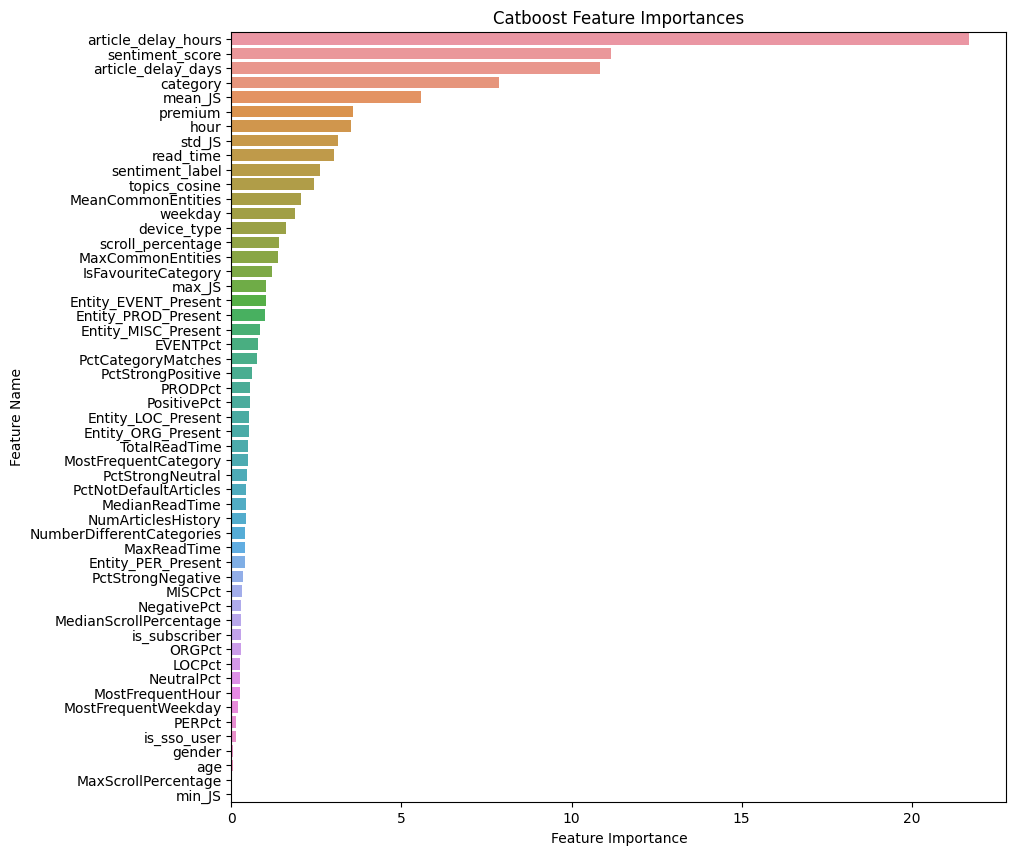

In [22]:
sorted_importances = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 10))
sns.barplot(x=feature_importances[sorted_importances], y=np.array(X.columns)[sorted_importances])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Catboost Feature Importances')

In [23]:
del history_train
del train_ds
del behaviors_train
gc.collect()

5

# Model Evaluation

In [31]:
%%time

columns = ['category', 'article_type', 'sentiment_label', 'sentiment_score']
return_dtypes = [pl.Int64, pl.String, pl.String, pl.Float64]
with Progress() as progress: 
    
    tasks = {}
    for col in columns:
        tasks[col] = progress.add_task(f"Getting {col}", total=history_val.shape[0])
    tasks['entity_groups'] = progress.add_task("Getting entity_groups", total=history_val.shape[0])
    tasks['entity_groups_detailed'] = progress.add_task("Getting detailed entity_groups", total=history_val.shape[0])
    tasks['topics'] = progress.add_task("Getting topics", total=history_val.shape[0])

    history_val = history_val.with_columns(
        [pl.col('article_id_fixed').map_elements(get_single_feature_function(col, tasks[col]), 
                                                 return_dtype=pl.List(dtype)).alias(col)
         for col, dtype in zip(columns, return_dtypes)] + \
        [pl.col('article_id_fixed').map_elements(get_unique_list_exploded_feature_function('entity_groups', tasks['entity_groups']), 
                                                 return_dtype=pl.List(pl.String)).alias('entity_groups'),
         pl.col('article_id_fixed').map_elements(get_unique_list_exploded_feature_function('topics', tasks['topics']), 
                                                 return_dtype=pl.List(pl.String)).alias('topics_flatten'),
         pl.col('article_id_fixed').map_elements(get_unique_list_feature_function('entity_groups', tasks['entity_groups_detailed']), 
                                                 return_dtype=pl.List(pl.List(pl.String))).alias('entity_groups_detailed')]
    )
    
history_val = history_val.with_columns(
    pl.struct(['sentiment_label', 'sentiment_score']).map_elements(
        lambda x: sentiment_score_strong_pct(x['sentiment_label'], x['sentiment_score'], 'Negative')
    ).alias('PctStrongNegative'),
    pl.struct(['sentiment_label', 'sentiment_score']).map_elements(
        lambda x: sentiment_score_strong_pct(x['sentiment_label'], x['sentiment_score'], 'Neutral')
    ).alias('PctStrongNeutral'),
    pl.struct(['sentiment_label', 'sentiment_score']).map_elements(
        lambda x: sentiment_score_strong_pct(x['sentiment_label'], x['sentiment_score'], 'Positive')
    ).alias('PctStrongPositive')
).with_columns(
    pl.col('read_time_fixed').list.len().alias('NumArticlesHistory'),
    pl.col('read_time_fixed').list.median().alias('MedianReadTime'),
    pl.col('read_time_fixed').list.max().alias('MaxReadTime'),
    pl.col('read_time_fixed').list.sum().alias('TotalReadTime'),
    pl.col('scroll_percentage_fixed').list.median().alias('MedianScrollPercentage'),
    pl.col('scroll_percentage_fixed').list.max().alias('MaxScrollPercentage'),
    pl.col('impression_time_fixed').list.eval(pl.element().dt.weekday()).alias('weekdays'),
    pl.col('impression_time_fixed').list.eval(pl.element().dt.hour()).alias('hours'),
).with_columns(
    pl.col('weekdays').map_elements(lambda x: stats.mode(x)[0], return_dtype=pl.Int64).cast(pl.Int8).alias('MostFrequentWeekday'),
    pl.col('hours').map_elements(lambda x: stats.mode(x)[0], return_dtype=pl.Int64).cast(pl.Int8).alias('MostFrequentHour'),
    pl.col('category').map_elements(lambda x: stats.mode(x)[0], return_dtype=pl.Int64).cast(pl.Int16).alias('MostFrequentCategory'),
    (1 - (pl.col('article_type').list.count_matches('article_default') / pl.col('NumArticlesHistory'))).alias('PctNotDefaultArticles'),
    (pl.col('sentiment_label').list.count_matches('Negative') / pl.col('NumArticlesHistory')).alias('NegativePct'),
    (pl.col('sentiment_label').list.count_matches('Positive') / pl.col('NumArticlesHistory')).alias('PositivePct'),
    (pl.col('sentiment_label').list.count_matches('Neutral') / pl.col('NumArticlesHistory')).alias('NeutralPct'),
).drop(
    ['read_time_fixed', 'scroll_percentage_fixed', 'impression_time_fixed', 
     'weekdays', 'hours', 'sentiment_label', 'sentiment_score', 'article_type']
).with_columns(
    (pl.col('entity_groups').list.count_matches(entity) / pl.col('NumArticlesHistory')).alias(f'{entity}Pct')
    for entity in unique_entities
).drop('entity_groups')

history_val.head(2)

Output()

CPU times: user 4min 7s, sys: 22.4 s, total: 4min 30s
Wall time: 2min 51s


user_id,article_id_fixed,category,topics_flatten,entity_groups_detailed,PctStrongNegative,PctStrongNeutral,PctStrongPositive,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,MostFrequentWeekday,MostFrequentHour,MostFrequentCategory,PctNotDefaultArticles,NegativePct,PositivePct,NeutralPct,MISCPct,PERPct,LOCPct,PRODPct,ORGPct,EVENTPct
u32,list[i32],list[i64],list[str],list[list[str]],f64,f64,f64,u32,f32,f32,f32,f32,f32,i8,i8,i16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
14241,"[9578072, 9749349, … 9779289]","[457, 457, … 118]","[""Samfund"", ""Mad og drikke"", … ""Politik""]","[[], [""PER"", ""ORG""], … [""ORG"", ""PER"", ""LOC""]]",0.524476,0.167832,0.055944,161,18.0,1574.0,7608.0,98.0,100.0,3,13,118,0.130435,0.52795,0.10559,0.254658,0.136646,0.763975,0.701863,0.180124,0.801242,0.099379
20396,"[9748482, 9748916, … 9779489]","[140, 414, … 140]","[""Kendt"", ""Kriminalitet"", … ""Katastrofe""]","[[""LOC"", ""ORG"", ""PER""], [""ORG"", ""PER"", … ""LOC""], … [""LOC"", ""PER"", ""ORG""]]",0.459016,0.180328,0.081967,74,40.5,1278.0,5406.0,100.0,100.0,7,15,414,0.22973,0.459459,0.121622,0.243243,0.216216,0.756757,0.648649,0.256757,0.783784,0.121622


In [25]:
# no sampling since for evaluation all the predictions should be needed
val_ds = behaviors_val.pipe(create_binary_labels_column, shuffle=True, seed=123) \
    .with_columns(pl.col("labels").list.len().name.suffix("_len")) \
    .select(['impression_id', 'article_ids_inview', 'article_id', 'impression_time', 'labels', 
             'device_type', 'read_time', 'scroll_percentage', 'user_id', 'is_sso_user', 'gender',
             'age', 'is_subscriber']) \
    .explode(['article_ids_inview', 'labels']) \
    .rename({'article_ids_inview': 'article', 'labels': 'target'}) \
    .with_columns(
        pl.col('impression_time').dt.weekday().alias('weekday'),
        pl.col('impression_time').dt.hour().alias('hour'),
        pl.col('article').cast(pl.Int32),
    ).join(articles.select(['article_id', 'premium', 'published_time', 'category', 
                            'sentiment_score', 'sentiment_label', 'entity_groups']),
           left_on='article', right_on='article_id', how='left') \
    .with_columns(
        (pl.col('impression_time') - pl.col('published_time')).dt.total_days().alias('article_delay_days'),
        (pl.col('impression_time') - pl.col('published_time')).dt.total_hours().alias('article_delay_hours')
    ).drop(['impression_time', 'published_time', 'article_id']) \
    .drop(['impression_time', 'published_time', 'article_id']) \
    .with_columns(
        pl.col('entity_groups').list.contains(entity).alias(f'Entity_{entity}_Present')
        for entity in unique_entities
    ).join(history_val.drop(['entity_groups_detailed', 'article_id_fixed', 'topics_flatten']), on='user_id', how='left').with_columns(
        (pl.col('category') == pl.col('MostFrequentCategory')).alias('IsFavouriteCategory'),
        pl.col('category_right').list.n_unique().alias('NumberDifferentCategories'),
        list_pct_matches_with_col('category_right', 'category').alias('PctCategoryMatches'),
    ).drop('category_right')
    
val_ds.head(2)

impression_id,article,target,device_type,read_time,scroll_percentage,user_id,is_sso_user,gender,age,is_subscriber,weekday,hour,premium,category,sentiment_score,sentiment_label,entity_groups,article_delay_days,article_delay_hours,Entity_MISC_Present,Entity_PER_Present,Entity_LOC_Present,Entity_PROD_Present,Entity_ORG_Present,Entity_EVENT_Present,PctStrongNegative,PctStrongNeutral,PctStrongPositive,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,MostFrequentWeekday,MostFrequentHour,MostFrequentCategory,PctNotDefaultArticles,NegativePct,PositivePct,NeutralPct,MISCPct,PERPct,LOCPct,PRODPct,ORGPct,EVENTPct,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches
u32,i32,i8,i8,f32,f32,u32,bool,i8,i8,bool,i8,i8,bool,i16,f32,str,list[str],i64,i64,bool,bool,bool,bool,bool,bool,f64,f64,f64,u32,f32,f32,f32,f32,f32,i8,i8,i16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,u32,f64
96791,9783865,0,2,9.0,null,22548,false,null,null,false,7,4,false,498,0.9793,"""Negative""","[""PROD"", ""PER"", … ""ORG""]",0,6,false,true,true,true,true,true,0.503937,0.11811,0.094488,130,16.0,650.0,4581.0,37.0,100.0,1,9,118,0.061538,0.576923,0.153846,0.246154,0.176923,0.823077,0.715385,0.292308,0.907692,0.223077,false,7,0.952756
96791,9784591,0,2,9.0,null,22548,false,null,null,false,7,4,false,142,0.9823,"""Negative""","[""ORG"", ""LOC"", … ""ORG""]",0,8,false,true,true,false,true,false,0.503937,0.11811,0.094488,130,16.0,650.0,4581.0,37.0,100.0,1,9,118,0.061538,0.576923,0.153846,0.246154,0.176923,0.823077,0.715385,0.292308,0.907692,0.223077,false,7,0.952756


In [26]:
val_ds.shape

(2928942, 51)

In [27]:
%%time

entities_df = pl.concat(
    (
        rows.select(['impression_id', 'user_id', 'article', 'entity_groups']) \
            .join(history_val.select(['user_id', 'entity_groups_detailed']), on='user_id', how='left') \
            .explode('entity_groups_detailed')
            .with_columns(
                pl.col('entity_groups').list.set_intersection(pl.col('entity_groups_detailed')).list.len().alias('common_entities')
            ).drop(['entity_groups_detailed', 'entity_groups']) \
            .group_by(['impression_id', 'article']).agg(
                pl.col('common_entities').mean().alias('MeanCommonEntities'),
                pl.col('common_entities').max().alias('MaxCommonEntities'),
            )
        for rows in tqdm.tqdm(val_ds.iter_slices(100), total=val_ds.shape[0] // 100)
    )
)
val_ds = val_ds.join(entities_df, on=['impression_id', 'article'], how='left').drop(['entity_groups'])
val_ds.head(2)

29290it [13:33, 36.00it/s]                           


CPU times: user 14min 10s, sys: 1min 40s, total: 15min 50s
Wall time: 13min 34s


impression_id,article,target,device_type,read_time,scroll_percentage,user_id,is_sso_user,gender,age,is_subscriber,weekday,hour,premium,category,sentiment_score,sentiment_label,article_delay_days,article_delay_hours,Entity_MISC_Present,Entity_PER_Present,Entity_LOC_Present,Entity_PROD_Present,Entity_ORG_Present,Entity_EVENT_Present,PctStrongNegative,PctStrongNeutral,PctStrongPositive,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,MostFrequentWeekday,MostFrequentHour,MostFrequentCategory,PctNotDefaultArticles,NegativePct,PositivePct,NeutralPct,MISCPct,PERPct,LOCPct,PRODPct,ORGPct,EVENTPct,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches,MeanCommonEntities,MaxCommonEntities
u32,i32,i8,i8,f32,f32,u32,bool,i8,i8,bool,i8,i8,bool,i16,f32,str,i64,i64,bool,bool,bool,bool,bool,bool,f64,f64,f64,u32,f32,f32,f32,f32,f32,i8,i8,i16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,u32,f64,f64,u32
96791,9783865,0,2,9.0,null,22548,false,null,null,false,7,4,false,498,0.9793,"""Negative""",0,6,false,true,true,true,true,true,0.503937,0.11811,0.094488,130,16.0,650.0,4581.0,37.0,100.0,1,9,118,0.061538,0.576923,0.153846,0.246154,0.176923,0.823077,0.715385,0.292308,0.907692,0.223077,false,7,0.952756,3.031496,5
96791,9784591,0,2,9.0,null,22548,false,null,null,false,7,4,false,142,0.9823,"""Negative""",0,8,false,true,true,false,true,false,0.503937,0.11811,0.094488,130,16.0,650.0,4581.0,37.0,100.0,1,9,118,0.061538,0.576923,0.153846,0.246154,0.176923,0.823077,0.715385,0.292308,0.907692,0.223077,false,7,0.952756,2.503937,3


In [34]:
history_val = history_val.with_columns(
    pl.Series(
        vectorizer.transform(
            history_val.with_columns(pl.col('topics_flatten').list.join(separator=' '))['topics_flatten'].to_list()
        ).toarray()
    ).alias('topics_flatten_idf')
)

topics_similarity_df = pl.concat(
    (
        rows.select(["impression_id", "user_id", "article"])
            .join(articles.select('article_id', 'topics_idf'), left_on='article', right_on='article_id', how='left')
            .join(history_val.select(['user_id', 'topics_flatten_idf']), on="user_id",how="left")
            .with_columns(
                pl.struct(['topics_idf', 'topics_flatten_idf']).map_elements(
                    lambda x: cosine_similarity(x['topics_idf'], x['topics_flatten_idf']), return_dtype=pl.Float64
                ).cast(pl.Float32).alias('topics_cosine'),
            ).select(['impression_id', 'article', 'topics_cosine'])
        for rows in tqdm.tqdm(val_ds.iter_slices(100), total=val_ds.shape[0] // 100)
    )
)
val_ds = val_ds.join(topics_similarity_df, on=['impression_id', 'article'], how='left')
val_ds = add_features_JS_history_topics(val_ds, articles, history_val)
val_ds.head(2)

impression_id,article,target,device_type,read_time,scroll_percentage,user_id,is_sso_user,gender,age,is_subscriber,weekday,hour,premium,category,sentiment_score,sentiment_label,article_delay_days,article_delay_hours,Entity_MISC_Present,Entity_PER_Present,Entity_LOC_Present,Entity_PROD_Present,Entity_ORG_Present,Entity_EVENT_Present,PctStrongNegative,PctStrongNeutral,PctStrongPositive,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,MostFrequentWeekday,MostFrequentHour,MostFrequentCategory,PctNotDefaultArticles,NegativePct,PositivePct,NeutralPct,MISCPct,PERPct,LOCPct,PRODPct,ORGPct,EVENTPct,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches,MeanCommonEntities,MaxCommonEntities,topics_cosine,mean_JS,min_JS,max_JS,std_JS
u32,i32,i8,i8,f32,f32,u32,bool,i8,i8,bool,i8,i8,bool,i16,f32,str,i64,i64,bool,bool,bool,bool,bool,bool,f64,f64,f64,u32,f32,f32,f32,f32,f32,i8,i8,i16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,u32,f64,f64,u32,f32,f64,f64,f64,f64
96791,9783865,0,2,9.0,null,22548,false,null,null,false,7,4,false,498,0.9793,"""Negative""",0,6,false,true,true,true,true,true,0.503937,0.11811,0.094488,130,16.0,650.0,4581.0,37.0,100.0,1,9,118,0.061538,0.576923,0.153846,0.246154,0.176923,0.823077,0.715385,0.292308,0.907692,0.223077,false,7,0.952756,3.031496,5,0.303267,0.106309,0.0,0.666667,0.139516
96791,9784591,0,2,9.0,null,22548,false,null,null,false,7,4,false,142,0.9823,"""Negative""",0,8,false,true,true,false,true,false,0.503937,0.11811,0.094488,130,16.0,650.0,4581.0,37.0,100.0,1,9,118,0.061538,0.576923,0.153846,0.246154,0.176923,0.823077,0.715385,0.292308,0.907692,0.223077,false,7,0.952756,2.503937,3,0.431995,0.159201,0.0,1.0,0.288552


In [35]:
del history_val
del articles
del behaviors_val

gc.collect()

0

In [36]:
val_ds.shape

(2928942, 57)

In [37]:
val_ds = val_ds.with_columns(
    pl.col('gender').fill_null(2),
)
# impression_id will be later useful for evaluation
val_ds_pandas = val_ds.drop(['impression_id', 'article', 'user_id']).to_pandas()

val_ds_pandas[categorical_columns] = val_ds_pandas[categorical_columns].astype('category')

X_val = val_ds_pandas.drop(columns=['target'])
y_val = val_ds_pandas['target']

# doint model.predict_proba(...)[:, 1] to take only the probability of class 1
# while by doing [:, 0] we take the probability of class 0
val_ds = val_ds.with_columns(pl.Series(model.predict_proba(X_val)[:, 1]).alias('prediction'))
val_ds.select(['impression_id', 'target', 'prediction'])

impression_id,target,prediction
u32,i8,f64
96791,0,0.48885
96791,0,0.584394
96791,0,0.578131
96791,1,0.480637
96791,0,0.517762
…,…,…
579552453,0,0.116969
579552453,0,0.081481
579552453,1,0.105973


In [38]:
evaluation_ds = val_ds.group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
evaluation_ds

impression_id,target,prediction
u32,list[i8],list[f64]
487720496,"[0, 0, … 0]","[0.587158, 0.047137, … 0.494334]"
573683608,"[0, 0, … 0]","[0.516136, 0.321093, … 0.300446]"
168393695,"[0, 0, … 1]","[0.29594, 0.239637, … 0.076814]"
378544839,"[0, 0, … 0]","[0.071899, 0.100469, … 0.165064]"
259373812,"[0, 0, … 0]","[0.768352, 0.322309, … 0.320212]"
…,…,…
531698863,"[0, 0, … 0]","[0.490181, 0.592382, … 0.018863]"
205729132,"[1, 0, … 0]","[0.242412, 0.032998, … 0.037978]"
314911613,"[0, 0, … 0]","[0.481587, 0.162556, … 0.144886]"


In [39]:
%%time

met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['prediction'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

CPU times: user 5min 19s, sys: 25.5 ms, total: 5min 19s
Wall time: 5min 19s


<MetricEvaluator class>: 
 {
    "auc": 0.7119646696396343,
    "mrr": 0.4834254808329432,
    "ndcg@5": 0.541254245753312,
    "ndcg@10": 0.5873395962112503
}